In [ ]:
!git clone https://github.com/Marcelo7089/VRP_Data_ACO.git

Cloning into 'VRP_DATA'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


shortest_path: ([(0, 11), (11, 3), (3, 22), (22, 8), (8, 12), (12, 13), (13, 19), (19, 1), (1, 14), (14, 18), (18, 17), (17, 21), (21, 16), (16, 9), (9, 4), (4, 23), (23, 5), (5, 7), (7, 20), (20, 6), (6, 2), (2, 10), (10, 15), (15, 0)], 1290.0)


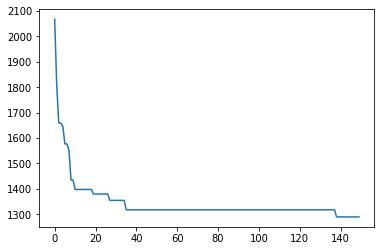

In [ ]:
import random as rn
import numpy as np
from numpy.random import choice as np_choice
from math import sqrt
import matplotlib.pyplot as plt
import json

class AntColony(object):

    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
        Example:
            ant_colony = AntColony(distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
        """
        self.distances  = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        distance_logs=[]
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path
            distance_logs.append(all_time_shortest_path[1])                      
        return all_time_shortest_path,distance_logs

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started    
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = (pheromone ** self.alpha) * (( 1.0 / dist) ** self.beta)

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move


#Static TSP Instance
# distances = np.array([[np.inf, 2, 2, 5, 7],
#                       [2, np.inf, 4, 8, 2],
#                       [2, 4, np.inf, 1, 3],
#                       [5, 8, 1, np.inf, 2],
#                       [7, 2, 3, 2, np.inf]])


#Dinamic TSP Instance, changing the value of n_nodes will change the
#Instance size
# n_nodes=100
# dist=lambda x,y: sqrt(((x[0]-y[0])**2)+((x[1]-y[1])**2))
# l=[(rn.random()*1000,rn.random()*1000) for i in range(n_nodes)]
# distances=np.array([[np.inf if i==j else dist(l[i],l[j]) for i in range(len(l))] for j in range(len(l))])


#Presolved TSP Instance
with open("VRP_DATA/Example2.json", "r") as tsp_data:
    tsp = json.load(tsp_data)

distances = tsp["DistanceMatrix"]
tour_size=tsp["TourSize"]
for i in range(tour_size):
  distances[i][i]=np.inf
distances=np.array(distances)




ant_colony = AntColony(distances, 50, 50, 150, 0.7, alpha=1, beta=1)
shortest_path,log = ant_colony.run()
print ("shortest_path: {}".format(shortest_path))
plt.plot(log)
plt.show()